# Identifying Cells with Optogenetics

In this section you will learn how to access the optogenetic data within the Neuropixels dataset and plot your data. In these experiments, light-gated ion channels were expressed in mice in a Cre-dependent manner. These ion channels elicit a response in Cre+ cells when light is shined on the surface of the brain. The concept behind this procedure is that only units with our cre-line of interest will respond to the light allowing for subrgroups of neuronal untis to be identified and analyzed across differing genotypes. 

**Note**: the presence of light artifacts can create the appearance of false positives, and false negatives (cells that are Cre+ but do not respond to light) are nearly impossible to avoid. We will go over how to deal with these cases later in the notebook. 

In [1]:
# Import necessary packages 
import numpy as np 
import pandas as pd 
import scipy as sp
import seaborn as sns
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

# Import the Neuropixels Cache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_project_api import EcephysProjectWarehouseApi
from allensdk.brain_observatory.ecephys.ecephys_project_api.rma_engine import RmaEngine

# Assign where data will be stored
manifest_path = 'manifest.json' 

# Create the EcephysProjectCache object
cache = EcephysProjectCache(manifest=manifest_path,
                            fetch_api=EcephysProjectWarehouseApi(RmaEngine(scheme="http",host="api.brain-map.org",timeout= 50 * 60)))          


Because we the light-gated ion channels are expressed in mice in a Cre-dependent manner, it is important to recall the different cre lines availabe to us in our sessions. 

In [2]:
all_sessions = cache.get_session_table()
all_sessions['full_genotype'].unique()

array(['Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
       'Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt', 'wt/wt',
       'Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'], dtype=object)

## Accessing Optogenetic Data

Before we begin downloading data, it is important to mention that the procedures in the optogenetic stimulation experiments have some inconsitencies. The light used to evoke the units' optogenetic response was switched from an LED light to a lazer a little more than halfway through the experiment to evoke a stronger response from the units. The cell below will return a list containing the session id's of the sessions where a lazer was used. 

In [3]:
# Halfway through expersiment, LED light was swapped for a Lazer to evoke stronger response
lazer = []

session_ids = all_sessions.index.values

for i in session_ids:
    if (i >= 789848216):
        lazer.append(i)
print(f" Sessions ID's conducted with lasers: \n {lazer}")

 Sessions ID's conducted with lasers: 
 [789848216, 791319847, 793224716, 794812542, 797828357, 798911424, 799864342, 816200189, 819186360, 819701982, 821695405, 829720705, 831882777, 835479236, 839068429, 839557629, 840012044, 847657808]


To ensure we can see clear optogenetic responses from our units, we will be working with a session that used a lazer to evoke these responses. We will download multiple sessions with different Cre Lines to compare responses between differing genotypes. 

In [4]:
# Assign Session IDs with differing cre lines
pvalb_session_id = all_sessions.index.values[-2]
sst_session_id = all_sessions.index.values[-4]

# Download a session for one of our cre lines using
session = cache.get_session_data(pvalb_session_id) # Lazer

print('Data Downloaded.')

Data Downloaded.


The optotagging stimuli is different than the stimulation presentations that were used in the previous section. To access the table containing the optogenetic stimuli data, execute `optogenetic_stimulation_epochs` on the session object. The table contains the start, stop, and duration of each light pulse as well as the pulse's condition and level. The `level` column contains the power level of the light source defined by the peak voltage of the control signal delivered to the light source. The type of pulse used is stored in the `condition` column and each pulse is defined below. 

- single square pulse: 5ms or 10ms duration
- half period of a cosine wave: 1 second duration
- 2.5 ms pulses at 10 Hz: 1 second duration

In [5]:
opto_table = session.optogenetic_stimulation_epochs

opto_table

,start_time,condition,level,stop_time,stimulus_name,duration
id,,,,,,
0,9208.93886,a single square pulse,0.8200,9208.94386,pulse,0.005
1,9210.82255,a single square pulse,0.8200,9210.83255,pulse,0.010
2,9212.89370,half-period of a cosine wave,0.6375,9213.89370,raised_cosine,1.000
3,9214.92632,a single square pulse,0.8200,9214.93132,pulse,0.005
4,9216.88637,a single square pulse,0.7375,9216.89137,pulse,0.005
...,...,...,...,...,...,...
295,9782.39422,a single square pulse,0.8200,9782.39922,pulse,0.005
296,9784.29428,a single square pulse,0.7375,9784.29928,pulse,0.005
297,9786.30825,a single square pulse,0.8200,9786.31825,pulse,0.010


## Aligning Spikes to Pulses 

Unlike the stimulus presentations that we covered in the previous section, there is no built in function for aligning spikes to light pulses in the Allen SDK. Below, we have copied a function from the Allen SDK Optotagging Analysis tutorial that does this for you. If you are interested, you can find the whole tutorial, <a href = 'https://github.com/jsiegle/AllenSDK/blob/opto-tutorial/doc_template/examples_root/examples/nb/ecephys_optotagging.ipynb'> here</a>.

The funtion below needs bin edges, optogenetic trials, and units in order to return the spike counts. For this reason, you must first specify your desired bins, optogenetic stimuli, and units of interest. We will be focusing units found in the `VISp` brain area. The Allen Institute has discovered that "10 ms pulses are the most useful stimulus for finding true light-evoked activity" <a href = 'https://github.com/jsiegle/AllenSDK/blob/opto-tutorial/doc_template/examples_root/examples/nb/ecephys_optotagging.ipynb'> (link) </a> so will subselect data with that stimulus. 

In [6]:
# Assign optogenetic stimuli
ss_10ms = opto_table[(opto_table['duration'] > 0.009) & (opto_table['duration'] < 0.02)]

# Assign units in brain area of interest
units_df = session.units
VISp_df = units_df[units_df['ecephys_structure_acronym'] == 'VISp']

# Assign time bins
time_resolution = 0.0005 # 0.5 ms bins
bin_edges = np.arange(-0.01, 0.025, time_resolution)


def optotagging_spike_counts(bin_edges, trials, units):
     
    time_resolution = np.mean(np.diff(bin_edges))

    spike_matrix = np.zeros( (len(trials), len(bin_edges), len(units)) )

    for unit_idx, unit_id in enumerate(units.index.values):

        spike_times = session.spike_times[unit_id]

        for trial_idx, trial_start in enumerate(trials.start_time.values):

            in_range = (spike_times > (trial_start + bin_edges[0])) * \
                       (spike_times < (trial_start + bin_edges[-1]))

            binned_times = ((spike_times[in_range] - (trial_start + bin_edges[0])) / time_resolution).astype('int')
            spike_matrix[trial_idx, binned_times, unit_idx] = 1

    return xr.DataArray(
        name='spike_counts',
        data=spike_matrix,
        coords={
            'trial_id': trials.index.values,
            'time_relative_to_stimulus_onset': bin_edges,
            'unit_id': units.index.values
        },
        dims=['trial_id', 'time_relative_to_stimulus_onset', 'unit_id']
    )

da = optotagging_spike_counts(bin_edges, ss_10ms, VISp_df)
da

<xarray.DataArray 'spike_counts' (trial_id: 75, time_relative_to_stimulus_onset: 70, unit_id: 46)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * trial_id                         (trial_id) int64 1 9 16 21 ... 294 297 298
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 -0.01 ... 0.0245
  * unit_id                          (unit_id) int64 951143596 ... 951144595

The function returns an `xarray.DataArray` that contains the spikes counts of each units. The dimensions for the array are the `trial_id` (an individual pulse from `opto_table`) the `time_relative_to_stimulus_onset`, and the `unit_id`. 

Looking at the DataArray, we can see that in this session there were 75 different times that a 10ms single pulse was given and 46 different units we are focusing on based on brain area. 

We can use the DataArray to plot a heatmap of units' response to the light pulses. The funtion below was also copied from the Allen SDK Optogenetic Analysis tutortial. The funtion takes our DataArray and reduces the data within by computing the mean spike counts across the `trial_id` dimension for every unit in the array. The reduced data is then plotted with respect to the time bins that we specified earlier. 

For more information on how to use `xarray.DataArray` objects, please visit <a href = 'http://xarray.pydata.org/en/stable/generated/xarray.DataArray.mean.html#xarray.DataArray.mean'> here</a>.

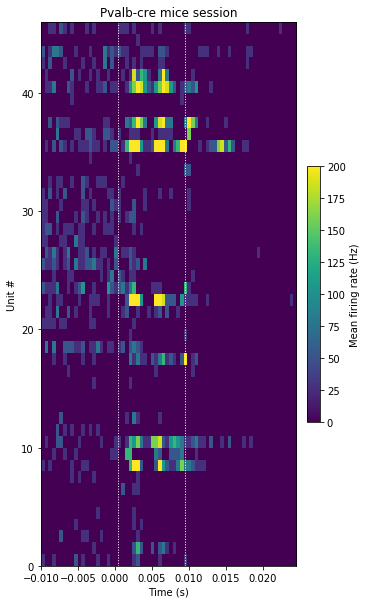

In [61]:
def plot_optotagging_response(da):

    plt.figure(figsize=(5,10))
    
    # Plot mean firing rate of each unit across each trial
    plt.imshow(da.mean(dim='trial_id').T / time_resolution, 
               extent=[np.min(bin_edges), np.max(bin_edges),
                       0, len(VISp_df)],
               aspect='auto', vmin=0, vmax=200)    
    
    # Plot Vertical lines indicating stimulus window 
    for bound in [0.0005, 0.0095]:
        plt.plot([bound, bound],[0, len(VISp_df)], ':', color='white', linewidth=1.0)

    plt.xlabel('Time (s)')
    plt.ylabel('Unit #')

    cb = plt.colorbar(fraction=0.046, pad=0.04)
    cb.set_label('Mean firing rate (Hz)')
    
plot_optotagging_response(da)
plt.title('Pvalb-cre mice session')
plt.show()

The vertical lines indicate the stimulus window. Increases of firing rate right at the onset of the simulus are considered unrelaible because they are more often then not stimulus artifacts. The same can be said about increases of firing rate at the end of stimulus window. 

There is a lot of variabilty in the firing rates of different cre lines. We can use this type of plot to compare responses between different cre lines and identify the difference in numbers of light-driven neural units. Below we will plot the same time of graph, but with data taken from a session that used the sst cre line. 

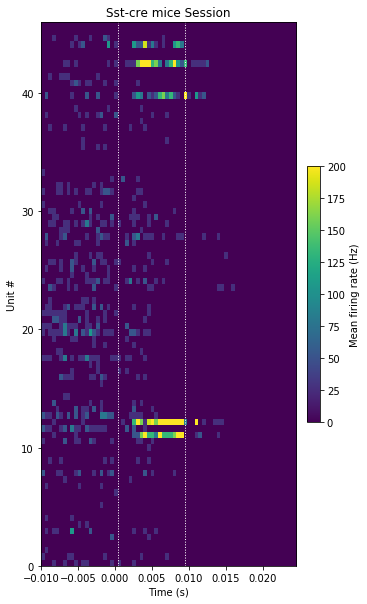

In [62]:
# Download new session with 'sst' cre line
session = cache.get_session_data(sst_session_id) 

# Assign new optogenetic table basesd on new session
opto_table2 = session.optogenetic_stimulation_epochs

# Assign optogenetic stimuli
ss_10ms_2 = opto_table2[(opto_table2['duration'] > 0.009) & (opto_table2['duration'] < 0.02)]

# Assign units in brain area of interest for new session
units_df_2 = session.units
VISp_df_2 = units_df_2[units_df_2['ecephys_structure_acronym'] == 'VISp']

# Assign spike counts
da2 = optotagging_spike_counts(bin_edges, ss_10ms_2, VISp_df_2)

plot_optotagging_response(da2)
plt.title('Sst-cre mice Session')
plt.show()

Comparing the two plots, one can see that there are less units increasing their firing rate in our session that utilized Sst-cre mice. 

A good way to use this data would be to comapare the baseline firing rate (i.e. firing rate before stimulus) to the evoked firing rate. We can do this by first slicing our time bins into two timeframes, `baseline` and `evoked`. The `baseline` timeframe will begin at the start of our time bins and end just before the stimulus onset. The `evoked` timeframe will begin immidiatley after the onset of the stimulus and end right before the end of the stimulus suration. 

We will then reduce our data to only the mean firing rate of each unit within each time frame.

In [63]:
# Assign time before stimulus occurs
baseline = da.sel(time_relative_to_stimulus_onset=slice(-0.01,-0.002))

# Assign Mean firing rate of each unit for time before the stimulus window 
baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

# Assign time within stimulus window
evoked = da.sel(time_relative_to_stimulus_onset=slice(0.001,0.009))

# Assign Mean firing rate of each unit for time within the stimulus window 
evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

evoked_rate

<xarray.DataArray 'spike_counts' (unit_id: 46)>
array([  8.33333333,   1.66666667,  18.33333333,   8.33333333,
        60.        , 121.66666667,   0.        ,   0.        ,
        96.66666667,  13.33333333, 198.33333333,   1.66666667,
         1.66666667,   1.66666667,   5.        ,   5.        ,
         8.33333333,   3.33333333,   0.        ,   8.33333333,
        13.33333333,   5.        ,  25.        , 131.66666667,
        18.33333333,   1.66666667,   1.66666667,  16.66666667,
        40.        ,   1.66666667,   1.66666667,   0.        ,
         0.        ,  10.        ,   0.        ,  93.33333333,
        35.        ,  81.66666667,   1.66666667,   6.66666667,
         0.        ,   1.66666667,   3.33333333,   1.66666667,
        30.        ,   6.66666667])
Coordinates:
  * unit_id  (unit_id) int64 951143596 951143585 ... 951144438 951144595

We now have two DataArrays, one that contains the mean firing rate of the units at baseline, and one that contains the mean firing rate of the units during the pulse. Plotting a scatter plot with these two areas will show us how a unit's basline firing rate compares to its evoked firing rate. 

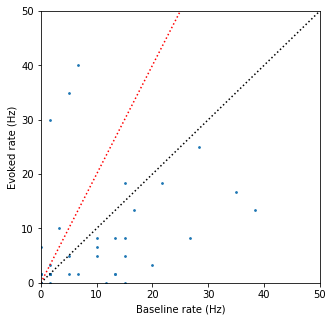

In [64]:
plt.figure(figsize=(5,5))

plt.scatter(baseline_rate, evoked_rate, s=3)

axis_limit = 50

# Black line though center represents no change in rate (1:1)
plt.plot([0,axis_limit],[0,axis_limit], ':k')

# Red line represents a 2x change in rate (2:1)
plt.plot([0,axis_limit],[0,axis_limit*2], ':r')

plt.xlim([0,axis_limit])
plt.ylim([0,axis_limit])

plt.xlabel('Baseline rate (Hz)')
_ = plt.ylabel('Evoked rate (Hz)')

Each point represent a neural unit. The black line represents a 1:1 ratio in the evoked firing rate to the baseline firing rate of that unit. Any unit below that black line had a larger response at baseline than it did to the light pulse. The red line represents a 2:1 ratio in the evoked firing rate to the baseline firing rate of that unit. We can subselect units whose evoked firing rate is 2x larger than baseline to ensure these are units that are reliabily responding to the light pulse.

## Identifying Fast-Paced Waveforms

In [65]:
# Return units whose firing rates doubled when light was on
cre_pos_units = da.unit_id[(evoked_rate / (baseline_rate + 1)) > 2].values # add 1 to prevent divide-by-zero errors

cre_pos_units

array([951143673, 951143733, 951143770, 951143807, 951143940, 951144042,
       951144103, 951144165, 951144148, 951144796, 951144801, 951144438])

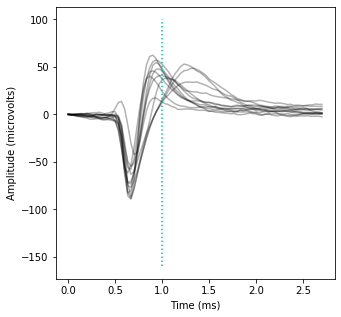

In [66]:
plt.figure(figsize=(5,5))

# Reload pvalb session
session = cache.get_session_data(pvalb_session_id)

for unit_id in cre_pos_units:
    
    peak_channel = session.units.loc[unit_id].peak_channel_id
    wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel)
    
    plt.plot(wv.time * 1000, wv, 'k', alpha=0.3)

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (microvolts)')
plt.plot([1.0, 1.0],[-160, 100],':c')
plt.show()

Waves that occur before the 1ms timestamp can be considered to be a response to the light pulse. Those that come later than 1ms are thought to be elicited by from retinal input rather than by the light pulse. 

We can compare two different cre lines like we did before, but this time compare the number of fast-paced waveforms to regular waveforms. 

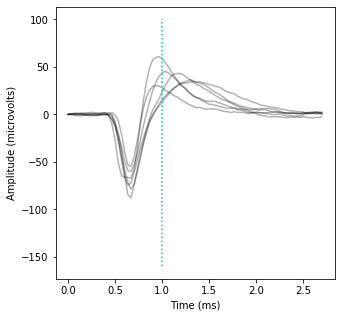

In [67]:
# Assign time before stimulus occurs
baseline2 = da2.sel(time_relative_to_stimulus_onset=slice(-0.01,-0.002))

# Assign Mean firing rate of each unit for time before the stimulus window 
baseline_rate2 = baseline2.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

# Assign time within stimulus window
evoked2 = da2.sel(time_relative_to_stimulus_onset=slice(0.001,0.009))

# Assign Mean firing rate of each unit for time within the stimulus window 
evoked_rate2 = evoked2.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

# Return units whose firing rates doubled when light was on 
cre_pos_units2 = da2.unit_id[(evoked_rate2 / (baseline_rate2 + 1)) > 2].values # add 1 to prevent divide-by-zero errors


plt.figure(figsize=(5,5))

# Reload sst session
session = cache.get_session_data(sst_session_id)

for unit_id in cre_pos_units2:
    
    peak_channel = session.units.loc[unit_id].peak_channel_id
    wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel)
    
    plt.plot(wv.time * 1000, wv, 'k', alpha=0.3)

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (microvolts)')
plt.plot([1.0, 1.0],[-160, 100],':c')
plt.show()

Comparing the two plots we can see that sst-cre mice had las units that were light-driven than the pvalb-cre mice. 